In [1]:
import os, sys, time, resource, re, gc, shutil
from django.db.models import Count
import matplotlib
#matplotlib.use('pgf')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django

from scipy.spatial import ConvexHull

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max

from scoping.models import *
from tmv_app.models import *
matplotlib.rcParams["figure.figsize"] = [7.2,4.5]
matplotlib.rcParams['axes.labelsize'] = 7 
matplotlib.rcParams['xtick.labelsize'] = 5
matplotlib.rcParams['ytick.labelsize'] = 5 


run_id = 758

In [2]:
c_ind = np.load('../data/c_ind.npy')
labels = np.load('../data/labels.npy')
tsne_results = np.load('../data/tsne_results.npy')
s_docs = np.load('../data/s_docs.npy')

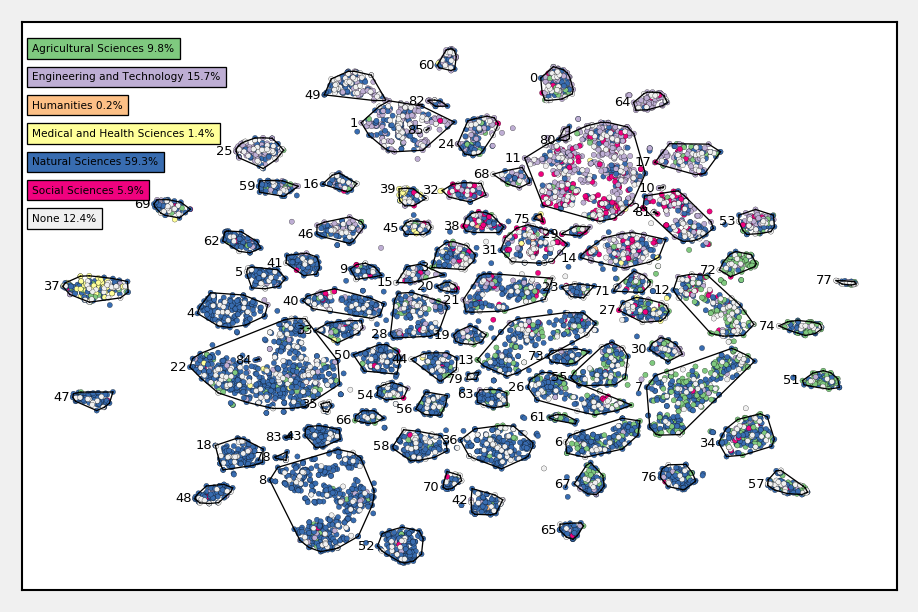

In [5]:
label_set = list(set(labels))

fig = plt.figure(dpi=188)

import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(label_set), vmax=max(label_set))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

df = pd.DataFrame()

colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
oecd_cats = list(Doc.objects.filter(id__in=s_docs).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=s_docs,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['color'] = colors[i]

for l in list(set(labels)):
    ind = np.argwhere(labels==l)
    cs = []
    sizes = []
    xs = []
    ys = []
    
    dids = []

    for i,did in enumerate(ind):
        x = tsne_results[did[0],0]
        y = tsne_results[did[0],1]
        col = "grey"
        for c in oecd_cats:
            if c_ind[did[0]] in c['docs']:
                col = c['color']
        cs.append(col)
        xs.append(x)
        ys.append(y)
        dids.append(c_ind[did[0]])
               
    if l !=-1:
        points = np.array([(xs[i],ys[i]) for i,v in enumerate(xs)])
        hull = ConvexHull(points)
        for i, simplex in enumerate(hull.simplices):
            plt.plot(
                points[simplex, 0], 
                points[simplex, 1], 
                'k-',
                linewidth=0.5
            )
            for j in range(len(points[simplex,0])):                
                if i==0 and j==0:
                    px = points[simplex,0][j]
                    py = points[simplex,1][j]
                else:
                    if points[simplex,0][j] < px:
                        px = points[simplex,0][j]
                        py = points[simplex,1][j]                    

        plt.text(
            px-1,
            py,
            l,
            va="center",
            ha="right",
            fontsize=5
        )
        
    plt.scatter(
        xs,
        ys,
        s=4,
        #s=sizes,
        linewidth=0.1,
        c=cs,
        edgecolor='k'
    )

for i,c in enumerate(oecd_cats):
    plt.text(
        -140,
        140-i*15,
        "{} {:.1%}".format(c['wc__oecd'],len(c['docs'])/10000),
        fontsize=4,
        bbox={
            'facecolor': c['color'],
            'pad': 2,
            'lw': 0.5
        }
    )

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,  
    labelbottom=False,
    left=False,
    labelleft=False
)
fig.patch.set_facecolor('#f0f0f0')   
plt.savefig(
    '../plots/tsne.png',   
    bbox_inches='tight',
    facecolor=fig.get_facecolor()
)

In [4]:
plt.close()